**Introduction**

> I'm going to break down this task in 4 major steps through this notebook 

which goes as follows:

*   Building model: shallow and deep network with non-linear acivations, fully-connected and convoluionsal layer,
*   Defining cost fuction,
*   List itemComputing derivatives of model parameters
*   Understanding the optimizer pipeline and how to update he model parameter.








**Downloading MNIST Dataset and Preprocessing**

> First code block downloads the MNIST dataset from web, and preprocess it, the data are separeated into a training set, and a test set, and the labels are encoded in [one-hot](https://www.geeksforgeeks.org/ml-one-hot-encoding-of-datasets-in-python/) form.



In [ ]:
##Downloading MNIST dataset anf storing it in directory _DATA
import array
import gzip
import os
from os import path
import struct
import urllib.request

import numpy as np


# path to data directory
_DATA = "/tmp/jax_example_data/"


def _download(url, filename):
    """Download a url to a file in the JAX data temp directory."""
    if not path.exists(_DATA):
        os.makedirs(_DATA)
    out_file = path.join(_DATA, filename)
    if not path.isfile(out_file):
        urllib.request.urlretrieve(url, out_file)
        print("downloaded {} to {}".format(url, _DATA))


def _partial_flatten(x):
    """Flatten all but the first dimension of an ndarray."""
    return np.reshape(x, (x.shape[0], -1))


def _one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)


def mnist_raw():
    """Download and parse the raw MNIST dataset."""
    # CVDF mirror of http://yann.lecun.com/exdb/mnist/
    base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

    def parse_labels(filename):
        with gzip.open(filename, "rb") as fh:
            _ = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, "rb") as fh:
            _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()),
                          dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
        _download(base_url + filename, filename)

    train_images = parse_images(path.join(_DATA, "train-images-idx3-ubyte.gz"))
    train_labels = parse_labels(path.join(_DATA, "train-labels-idx1-ubyte.gz"))
    test_images = parse_images(path.join(_DATA, "t10k-images-idx3-ubyte.gz"))
    test_labels = parse_labels(path.join(_DATA, "t10k-labels-idx1-ubyte.gz"))

    return train_images, train_labels, test_images, test_labels


def mnist(permute_train=False):
    """Download, parse and process MNIST data to unit scale and one-hot labels."""
    train_images, train_labels, test_images, test_labels = mnist_raw()

    train_images = _partial_flatten(train_images) / np.float32(255.)
    test_images = _partial_flatten(test_images) / np.float32(255.)
    train_labels = _one_hot(train_labels, 10)
    test_labels = _one_hot(test_labels, 10)

    if permute_train:
        perm = np.random.RandomState(0).permutation(train_images.shape[0])
        train_images = train_images[perm]
        train_labels = train_labels[perm]

    return train_images, train_labels, test_images, test_labels

**Minibatches**

Now that we've written the functions to download and preprocess the MNIST dataset, let's prepare it for training. Since we'll be using some variant of SGD (e.g., ADAM, etc.), we need to feed data into our machine learning model (e.g., a DNN) in random minibatches.

The function data_stream creates a python generator which returns one minibatch of the randomized training set at a time, until all training datapoints are exhausted. To do this efficiently, data_stream() defines a python generator. Generators are functions containing loops which yield a result one at a time until the loop is exhausted, rather than return the output.

If you're not familiar with generators, explore carefully the code below first. Make sure to explore the effect of the while-loop statement which is currently commented out. What is the purpose of having generators? What are generetors good/useful for? Explore the data_stream() generator below by printing a few small minibatches.


In [ ]:
def my_generator():
    #while True:
        for j in range(10):
            yield j
            
gen = my_generator()
print(gen) # shows a generator object

print('\nfirst loop:\n')   

# call generator
for i in range(4):
    print(i, next(gen) )
    
print('\nsecond loop:\n')    
    
for i in range(10):
    print(i, next(gen) )

<generator object my_generator at 0x7fb962d5c9d0>

first loop:

0 0
1 1
2 2
3 3

second loop:

0 4
1 5
2 6
3 7
4 8
5 9


StopIteration: ignored

In [ ]:
### define minibatches

# fix seed
seed=0
np.random.seed(seed)

##### define data variables and the minibatch generator
# load MNIST data
train_images, train_labels, test_images, test_labels = mnist()

print('\ntrain data: image shape: {}, label shape: {}.'.format(train_images.shape, train_labels.shape ))
print('test data : image shape: {}, label shape: {}.\n'.format(test_images.shape, test_labels.shape ))


# size of a single minibatch
batch_size=128 
# size of the trining set
num_train = train_images.shape[0] 
# define number of complete minibatches (data size need not be muptiple of batch_size)
num_complete_batches, leftover = divmod(num_train, batch_size)
# total number of minibatches is the smallest integer to fit all minibatches in the dataset
num_batches = num_complete_batches + bool(leftover)


def data_stream():
    """
    This function defines a generator which produces random batches of data, one at a time.
    
    """
    rng = np.random.RandomState(0)
    while True:
        perm = rng.permutation(num_train) # compute a random permutation
        for i in range(num_batches):
            batch_idx = perm[i * batch_size:(i + 1) * batch_size]
            yield train_images[batch_idx], train_labels[batch_idx]

# define the batches generator
batches = data_stream()


train data: image shape: (60000, 784), label shape: (60000, 10).
test data : image shape: (10000, 784), label shape: (10000, 10).



**Plot the Data**

Now we're going to plot the data, In title of the plot the corresponding label in one-hot form is given. below for each pixel values are squeezed in the interval of [0, 1].

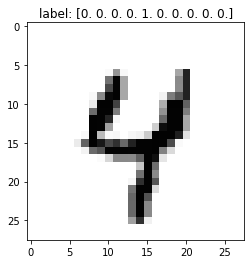

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
# static plots
%matplotlib inline 

### show the first data point as an example
n=1111 # test data point number

plt.imshow(test_images[n].reshape(28,28),cmap='Greys')
plt.title('label: {}'.format(test_labels[n]) )

plt.show()


**Defining The ML model**

We will first construct the SoftMax mode. it is a single layer nural network

In [ ]:
import jax.numpy as jnp # jax's numpy version with GPU support
from jax import random # used to define a RNG key to control the random input in JAX
from jax.experimental import stax # neural network library
from jax.experimental.stax import Dense, Relu, LogSoftmax # neural network layers

# set key for the RNG (see JAX docs)
rng = random.PRNGKey(seed)

# cast data into 1D image format suitable for fc layers: the shape should be (N_datapoints, 28*28)
train_images = train_images.reshape(-1,28*28) # -1: number of data points, (28*28): (height*width) dimensions of image
test_images = test_images.reshape(-1,28*28)

# define functions which initialize the parameters and evaluate the model
initialize_params, predict = stax.serial(
                                            ### SoftMax Regression
                                            Dense(10), # 10 output neurons
                                            LogSoftmax # NB: computes the log-probability
    
#                                             ### fully connected DNN
#                                             Dense(512), # 512 hidden neurons
#                                             Relu,
#                                             Dense(256), # 256 hidden neurons
#                                             Relu,
#                                             Dense(10), # 10 output neurons
#                                             LogSoftmax # NB: computes the log-probability
                                        )

# initialize the model parameters
output_shape, inital_params = initialize_params(rng, (-1, 28 * 28)) # fcc layer 28x28 pixes in each image

print('\noutput shape of the model is {}.\n'.format(output_shape))

# check how network works on 3 examples
predictions = predict(inital_params, test_images[0:3])

# print shape of output
print("actual output shape is:", predictions.shape)

# check if probability is conserved
print('log(softmax) values:', predictions[0])
print('conservation of probability', np.sum(jnp.exp(predictions), axis=1))


output shape of the model is (-1, 10).

actual output shape is: (3, 10)
log(softmax) values: [-2.2292223 -2.4820764 -2.7947464 -2.1780825 -1.9830027 -2.2069645
 -1.9345262 -2.6357243 -2.0653868 -3.1278682]
conservation of probability [1.        0.9999999 1.       ]


**Defining Lost/Cost Functions**

Lost and cost functions are defined to measure the performance of model. For this we are going to use jax.numpy instead of numpy for the obvios reasons that is optimizing the process to take less time.

In [ ]:
### define loss and accuracy functions

from jax import grad
from jax.tree_util import tree_flatten # jax params are stored as nested tuples; use this to manipulate tuples


def l2_regularizer(params, lmbda):
    """
    Define l2 regularizer: $\lambda \ sum_j ||theta_j||^2 $ for every parameter in the model $\theta_j$
    
    """
    return lmbda*jnp.sum(jnp.array([jnp.sum(jnp.abs(theta)**2) for theta in tree_flatten(params)[0] ]))


def loss(params, batch):
    """
    Define cost (or lost) function for softmax classification. 
    
    """
    inputs, targets = batch
    preds = predict(params, inputs)
    return -jnp.mean(jnp.sum(preds * targets, axis=1)) + l2_regularizer(params, 0.001)


def mean_accuracy(params, batch):
    """
    Define accuracy function: the mean number of datapoints which have correct preductions. 
    This function is not used for training; only to test the performance. 
    
    """
    inputs, targets = batch
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(predict(params, inputs), axis=1)
    return jnp.mean(predicted_class == target_class)

**Optimizer code**

Now, I'll define Optimizer for that I've used [jax.experimental.optimizers](https://web.archive.org/web/20210506031538/https://jax.readthedocs.io/en/latest/jax.experimental.optimizers.html) This module contains some convenient optimizer definitions, specifically initialization and update functions, which can be used with ndarrays or arbitrarily-nested tuple/list/dicts of ndarrays.

I'm adding a @jit decorator (Just-In-Time compiler) to the update function. This will make jax compile the update() function to give speedy results (even on the CPU!).

In [ ]:
### define generalized gradient descent optimizer and a function to update model parameters

from jax.experimental import optimizers # gradient descent optimizers
from jax import jit

step_size = 0.001 # step size or learning rate 
momentum_mass = 0.9 # "gamma" parameter in GD+momentum

# compute optimizer functions
opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)


# define function which updates the parameters using the change computed by the optimizer
@jit # Just In Time compilation speeds up the code; requires to use jnp everywhere; remove when debugging
def update(i, opt_state, batch):
    """
    i: int,
        counter to count how many update steps we have performed
    opt_state: object,
        the state of the optimizer
    batch: np.array
        batch containing the data used to update the model
        
    Returns: 
    opt_state: object,
        the new state of the optimizer
        
    """
    # get current parameters of the model
    current_params = get_params(opt_state)
    # compute gradients
    grad_params = grad(loss)(current_params, batch)
    # use the optimizer to perform the update using opt_update
    return opt_update(i, grad_params, opt_state)

**Training Model**

Now we can start with the training part. We train model in epochs. In each epoch, we loop over the number of minibatches to exhaust the training set. We update parameters for each batch. Therefore, we use a variable itercount to count the number of updates.
Once we've done the update, we can read off the model parameters and check the current loss and model accuracy on the test set for the given epoch.

In [ ]:
### Train model

import time
import itertools

# define geenrator to count the number of updates
itercount = itertools.count()

# define number of training epochs
num_epochs = 101

# define figures of merit
train_accuracy=np.zeros(num_epochs)
test_accuracy=np.zeros_like(train_accuracy)

print("\nStarting training...\n")

# set the initial model parameters in the optimizer
opt_state = opt_init(inital_params)

# loop over the number of training epochs
for epoch in range(num_epochs): 
    
    ### record time
    start_time = time.time()
    
    ### train in minibatches until the entire dataset is exhausted: 
    # the entire dataset is divided into _random_ minibatches; 
    # all minibatches are shown to the model before going to next epoch
    for _ in range(num_batches):
        # use the data to update the model parameters
        opt_state = update(next(itercount), opt_state, next(batches))
        
    ### record time needed for a single epoch
    epoch_time = time.time() - start_time
    
    ### evaluate performance of the model at each fixed epoch
    
    # retrieve current model parameters
    params = get_params(opt_state)
    
    # measure the accuracy on the training and test datasets
    train_accuracy[epoch] = mean_accuracy(params, (train_images, train_labels))
    test_accuracy[epoch] = mean_accuracy(params, (test_images, test_labels))
    
    # print results every 10 epochs
    if epoch % 10 == 0:
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set accuracy {}".format(train_accuracy[epoch]))
        print("Test set accuracy {}\n".format(test_accuracy[epoch]))


Starting training...

Epoch 0 in 0.61 sec
Training set accuracy 0.8258500099182129
Test set accuracy 0.8351999521255493

Epoch 10 in 0.27 sec
Training set accuracy 0.8929499983787537
Test set accuracy 0.9002999663352966

Epoch 20 in 0.26 sec
Training set accuracy 0.9025333523750305
Test set accuracy 0.9090999960899353

Epoch 30 in 0.26 sec
Training set accuracy 0.9068499803543091
Test set accuracy 0.9120999574661255

Epoch 40 in 0.27 sec
Training set accuracy 0.9095333218574524
Test set accuracy 0.9143999814987183

Epoch 50 in 0.27 sec
Training set accuracy 0.911466658115387
Test set accuracy 0.9151999950408936

Epoch 60 in 0.26 sec
Training set accuracy 0.912933349609375
Test set accuracy 0.9157999753952026

Epoch 70 in 0.26 sec
Training set accuracy 0.9145166873931885
Test set accuracy 0.9160999655723572

Epoch 80 in 0.26 sec
Training set accuracy 0.914900004863739
Test set accuracy 0.9158999919891357

Epoch 90 in 0.26 sec
Training set accuracy 0.9155666828155518
Test set accuracy 0

Below we compare the training and test average accuracy curves.

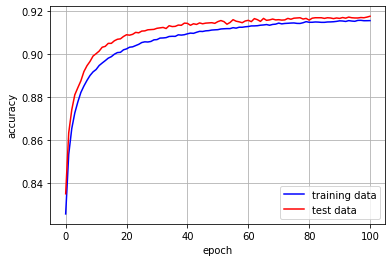

In [ ]:
### plot and examine learning curves

epochs=list(range(num_epochs))

plt.plot(epochs, train_accuracy, '-b', label='training data' )
plt.plot(epochs, test_accuracy, '-r', label='test data' )

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.grid()
plt.legend()
plt.show()

Now examining the trained weights:

This is a first attempt to answer the question what the ML model learns and how it does the classification.


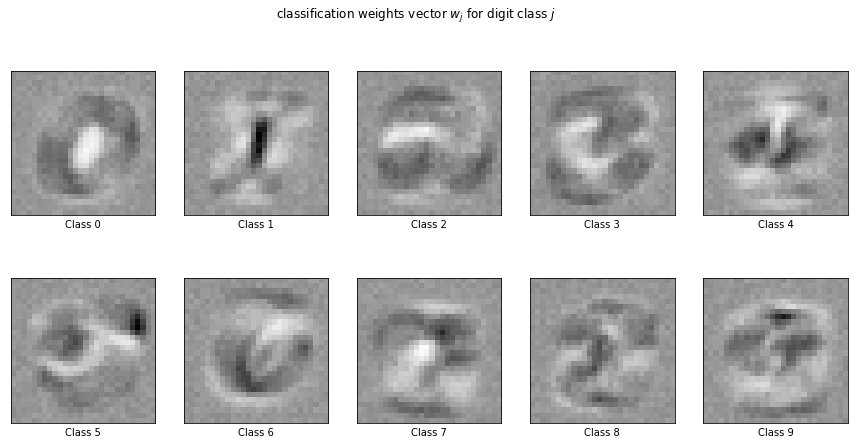

In [ ]:
### plot weights vs the pixel position (works only for a single layer)
### code works only SoftMax regression (!)

from jax. tree_util import tree_flatten # jax params are stored as nested tuples; use this to manipulate tuples

# extract weights and biases using tree_flatten
params = get_params(opt_state)
weights, biases  = tree_flatten(params)[0]

# print the weights (biases are not so interesting)
plt.figure(figsize=(15, 7)) # figure size 

scale = np.abs(weights).max() # define overall scale

for i in range(10): # loop over the number of weights
    
    plot = plt.subplot(2, 5, i + 1)
    plot.imshow(weights[:,i].reshape(28, 28), interpolation='nearest', cmap=plt.cm.Greys, vmin=-scale, vmax=scale)
    plot.set_xticks(())
    plot.set_yticks(())
    plot.set_xlabel('Class %i' % i)
    
plt.suptitle('classification weights vector $w_j$ for digit class $j$')

plt.show()

**CNN Model**

Convolutional layers know about the dimensionality of the input. In our case, the data is two-domensional, and thus needs to be reshaped accordingly.

In [ ]:
### Convolutional Neural network

from jax.experimental.stax import GeneralConv, Flatten # neural network layers


# cast data into 2D image format
train_images = train_images.reshape(-1,1,28,28) # -1: number of data points, 1: input channels, (28,28) = (height, width) dimensions of image
test_images = test_images.reshape(-1,1,28,28)

# conv net convention
dim_nums=('NCHW', 'OIHW', 'NCHW') # default for (input, filters, output)

# define functions which initialize the parameters and evaluate the model
initialize_params, predict = stax.serial(    
                                            ### convolutional NN (CNN)
                                            GeneralConv(dim_nums, 16, (4,4), strides=(4,4) ), # 16 output channels, (4,4) filter
                                            Relu,
                                            GeneralConv(dim_nums, 32, (3,3), strides=(1,1) ), # 32 output channels, (3,3) filter
                                            Relu,
                                            Flatten, # flatten output
                                            Dense(256), # 256 hidden neurons
                                            Relu,
                                            Dense(10), # 10 output neurons
                                            LogSoftmax # NB: computes the log-probability
                                        )

# initialize the model parameters
output_shape, inital_params = initialize_params(rng, (-1, 1, 28, 28)) # conv layer, 1 input channel, 28x28 pixes in each image

print('\noutput shape of the model is {}.\n'.format(output_shape))

# check how network works on 3 examples
predictions = predict(inital_params, test_images[0:3])

# print shape of output
print("actual output shape is:", predictions.shape)

# check if probability is conserved
print('log(softmax) values:', predictions[0])
print('conservation of probability', np.sum(jnp.exp(predictions), axis=1))


output shape of the model is (-1, 10).

actual output shape is: (3, 10)
log(softmax) values: [-2.264744  -2.4081535 -2.2366064 -2.302778  -2.4543524 -2.3551545
 -2.2510574 -2.1797054 -2.268157  -2.3361628]
conservation of probability [1.0000001 1.0000001 1.0000001]
